# How to do Back Testing?

This notebook demonstrate how to perform back testing using `backtest` utility.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt

import a2rl as wi
from a2rl.nbtools import pprint, print  # Enable color outputs when rich is installed.
from a2rl.utils import backtest

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Setup

- Specify 0.8 ratio of data for training. The first 80% of dataframe rows starting from index 0 will be used for training.
- There are 3992 rows for training, 998 rows for test

In [2]:
wi_df = wi.read_csv_dataset(wi.sample_dataset_path("chiller"))
wi_df.add_value()

# Speed up training for demo purpose
wi_df = wi_df.iloc[:1000]
tokenizer = wi.AutoTokenizer(wi_df, block_size_row=2, train_ratio=0.8)
print(f"Train: {len(tokenizer.train_dataset)}, Test: {len(tokenizer.test_dataset)}")

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Train: 3992, Test: 998


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Train the model. In this example, we are going to train the model using `1 epoch` to speed up, you may need to adjust training configuration for your own use case.

In [3]:
model_dir = "model-backtest"

config = dict(
    epochs=1,
    batch_size=512,
    embedding_dim=512,
    gpt_n_layer=1,
    gpt_n_head=1,
    learning_rate=6e-4,
    num_workers=0,
    lr_decay=True,
)
config = {"train_config": config}

builder = wi.GPTBuilder(tokenizer, model_dir, config)

In [4]:
%%time
model = builder.fit()

2023-05-22 10:06:39.174 | INFO     | a2rl.simulator:fit:753 - {'epochs': 1, 'batch_size': 512, 'embedding_dim': 512, 'gpt_n_layer': 1, 'gpt_n_head': 1, 'learning_rate': 0.0006, 'num_workers': 0, 'lr_decay': True}


  0%|          | 0/8 [00:00<?, ?it/s]

2023-05-22 10:06:43.693 | INFO     | a2rl.mingpt.trainer:run_epoch:123 - test loss: 5.617769479751587


2023-05-22 10:06:43.695 | INFO     | a2rl.simulator:fit:787 - Training time in mins: 0.074


CPU times: user 8.15 s, sys: 478 ms, total: 8.63 s
Wall time: 4.54 s


## Back Test

- Prepare backtest data using a subset of test data. In this case rows with index `-910:-900` which fall within test dataset.
- Let's create a new dataframe assuming it is come hold out set, and then tokenized the dataframe using existing tokenizer.
- Since you have trained the model, you can access your tokenizer from `tokenizer` directly. Alternatively, you can get from `simulator.tokenizer`.

In [5]:
simulator = wi.Simulator(tokenizer, model)
test_df = wi_df.iloc[-910:-900].reset_index(drop=True)
display(test_df)

test_df_tokenized = tokenizer.field_tokenizer.transform(test_df)
display(test_df_tokenized)

timestamp staging  condenser_inlet_temp  evaporator_heat_load_rt   
0  2025-08-04 18:00:00       8                  28.6                    716.6  \
1  2025-08-04 19:00:00       4                  27.2                    767.8   
2  2025-08-04 20:00:00       1                  29.5                   1436.0   
3  2025-08-04 21:00:00       7                  28.0                   1200.5   
4  2025-08-04 22:00:00      10                  28.2                    811.4   
5  2025-08-04 23:00:00       9                  27.7                    803.8   
6  2025-08-05 00:00:00       4                  30.1                    852.4   
7  2025-08-05 01:00:00       8                  28.6                    631.5   
8  2025-08-05 02:00:00       3                  31.0                    970.5   
9  2025-08-05 03:00:00       7                  26.8                    896.5   

   system_power_consumption        value  
0                     973.7   713.670159  
1                     632.8  1274.284315  
2                    1001.4  1272.469218  
3                    1344.8  1031.874230  
4                    1085.7  1283.630440  
5                     824.9   916.735348  
6                    1014.9  1006.722570  
7                    1035.2  1331.785970  
8                    1024.1  1206.725221  
9                     520.0  1418.093945

condenser_inlet_temp  evaporator_heat_load_rt  staging   
0                    17                       68      352  \
1                     3                       76      348   
2                    26                      142      344   
3                    11                      138      351   
4                    13                       85      345   
5                     7                       83      353   
6                    32                       93      348   
7                    17                       57      352   
8                    40                      116      347   
9                     1                      102      351   

   system_power_consumption  value  
0                       216    252  
1                       156    326  
2                       220    326  
3                       242    303  
4                       232    328  
5                       186    284  
6                       223    300  
7                       226    333  
8                       224    320  
9                       147    338

- Let's use the first 2 rows as context, and have `backtest` function predict the next 8 rows.
- `true_df` is a convenient groundtruth dataframe returned to be used for comparison.

In [6]:
pred_df, true_df = backtest(
    test_df, simulator, start_row=0, context_rows=2, predict_rows=8, return_groudtruth=True
)

2023-05-22 10:06:43.808 | INFO     | a2rl.utils:backtest:122 - Initial context.shape=(1, 7)


2023-05-22 10:06:43.809 | INFO     | a2rl.utils:backtest:129 - Predicting row:1, curr_row_idx=1


2023-05-22 10:06:43.810 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[348]])


2023-05-22 10:06:43.822 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[223, 342]]), next_states=array([[17, 52]])


2023-05-22 10:06:43.823 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 12)


2023-05-22 10:06:43.824 | INFO     | a2rl.utils:backtest:129 - Predicting row:2, curr_row_idx=2


2023-05-22 10:06:43.825 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[344]])


2023-05-22 10:06:43.836 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[165, 244]]), next_states=array([[ 33, 109]])


2023-05-22 10:06:43.837 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 17)


2023-05-22 10:06:43.837 | INFO     | a2rl.utils:backtest:129 - Predicting row:3, curr_row_idx=3


2023-05-22 10:06:43.838 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[351]])


2023-05-22 10:06:43.849 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[226, 340]]), next_states=array([[28, 67]])


2023-05-22 10:06:43.850 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 22)


2023-05-22 10:06:43.851 | INFO     | a2rl.utils:backtest:129 - Predicting row:4, curr_row_idx=4


2023-05-22 10:06:43.852 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[345]])


2023-05-22 10:06:43.863 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[231, 305]]), next_states=array([[11, 78]])


2023-05-22 10:06:43.864 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 27)


2023-05-22 10:06:43.864 | INFO     | a2rl.utils:backtest:129 - Predicting row:5, curr_row_idx=5


2023-05-22 10:06:43.865 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[353]])


2023-05-22 10:06:43.876 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[232, 317]]), next_states=array([[ 21, 136]])


2023-05-22 10:06:43.877 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 32)


2023-05-22 10:06:43.878 | INFO     | a2rl.utils:backtest:129 - Predicting row:6, curr_row_idx=6


2023-05-22 10:06:43.879 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[348]])


2023-05-22 10:06:43.890 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[208, 294]]), next_states=array([[17, 69]])


2023-05-22 10:06:43.891 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 37)


2023-05-22 10:06:43.891 | INFO     | a2rl.utils:backtest:129 - Predicting row:7, curr_row_idx=7


2023-05-22 10:06:43.893 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[352]])


2023-05-22 10:06:43.908 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[156, 335]]), next_states=array([[ 35, 112]])


2023-05-22 10:06:43.909 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 42)


2023-05-22 10:06:43.910 | INFO     | a2rl.utils:backtest:129 - Predicting row:8, curr_row_idx=8


2023-05-22 10:06:43.911 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[347]])


2023-05-22 10:06:43.921 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[158, 342]]), next_states=array([[17, 87]])


2023-05-22 10:06:43.922 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 47)


2023-05-22 10:06:43.923 | INFO     | a2rl.utils:backtest:129 - Predicting row:9, curr_row_idx=9


2023-05-22 10:06:43.924 | DEBUG    | a2rl.utils:backtest:131 - hist_action=array([[351]])


2023-05-22 10:06:43.934 | DEBUG    | a2rl.utils:backtest:133 - reward=array([[145, 248]]), next_states=array([[ 13, 140]])


2023-05-22 10:06:43.935 | DEBUG    | a2rl.utils:backtest:136 - new_context.shape=(1, 52)


2023-05-22 10:06:43.936 | DEBUG    | a2rl.utils:backtest:142 - new_sequence.shape=(50,)


The number of rows returned by backtest is `context_rows + predict_rows`.

In [7]:
pred_df

condenser_inlet_temp  evaporator_heat_load_rt staging   
0                28.650                 715.5245       8  \
1                27.250                 765.0835       4   
2                28.650                 576.6105       1   
3                30.205                 933.2330       7   
4                29.750                 711.0155      10   
5                28.050                 774.8440       9   
6                29.050                1150.3535       4   
7                28.650                 721.4465       8   
8                30.304                 952.4120       3   
9                28.650                 816.0875       7   

   system_power_consumption        value  
0                  974.8800   712.317305  
1                 1017.2585  1615.877422  
2                  713.3945   581.756826  
3                 1036.2240  1453.694064  
4                 1079.8065  1053.205005  
5                 1090.9105  1174.986647  
6                  930.9185   975.234735  
7                  635.8025  1357.274873  
8                  654.7580  1615.877422  
9                  481.4470   660.180949

Now you can compare the states transitoin between simulator and groundtruth based on historical actions.

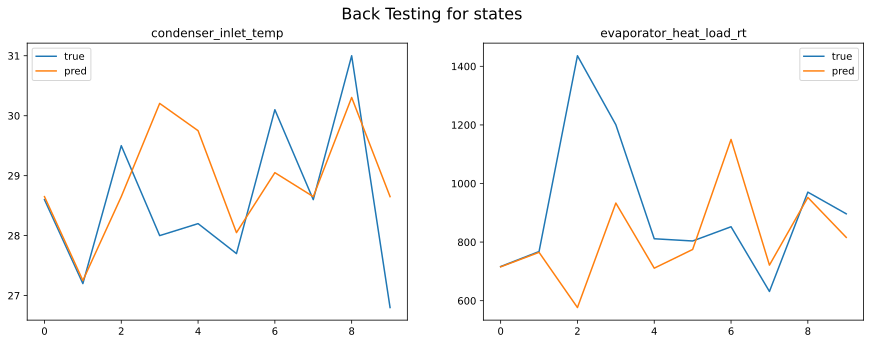

In [8]:
fig, axes = plt.subplots(int(len(true_df.states) / 2), 2, figsize=(15, 5))
fig.suptitle("Back Testing for states", fontsize=16)

for idx, col in enumerate(true_df.states):
    true_df[col].plot(ax=axes[idx])
    pred_df[col].plot(ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].legend(["true", "pred"])